#Web Scraping

The first thing we'll need to do to scrape a web page is to download the page. This can be done using the Python requests library

In [ ]:
import requests
page  = requests.get("https://stolkarjen.github.io/human-interaction/")

page

A 200 response means that the page downloaded successfully. Codes starting with a 4 or 5 indicate an error

Let's print out the HTML content

In [ ]:
page.content

Hopefully, you'll be able to recognize some of the following structure in the above content. Probably, there's simply too much content to parse manually

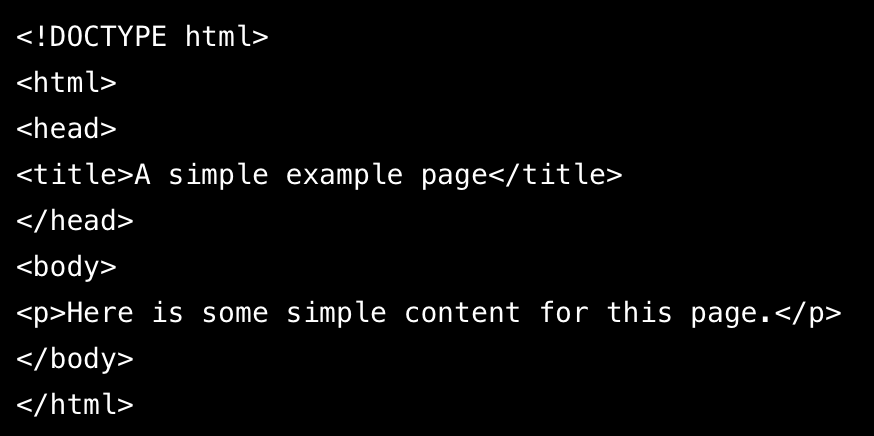

To more effectively parse a web page's content, we can use the BeautifulSoup library

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

print(soup.prettify())

The result is quite comparable, if not identical, to the source code at https://github.com/StolkArjen/human-interaction/blob/main/index.html

Finally, let's look for any tag that has the lecture-title class

In [ ]:
soup.find_all(class_="lecture-title")

#Scraping Twitter (needs a paid account as of late 2023)

To use the Twitter API, a Twitter Developer account is required. Please see here on how to obtain one for research purposes: https://developer.twitter.com/en/portal/petition/academic/is-it-right-for-you

After obtaining an account, let's install twarc2, version 2 of the API for accessing the TWitter ARChive. In this archive, each tweet is represented as a JSON object

In [ ]:
!pip install twarc --upgrade

Next, configure the account to provide you with archive access. This requires the API password/code you should have received through the above application procedure

In [ ]:
!twarc2 configure

We can now use the API to perform a search, the outcome of which is returned in json line (JSONL) format. The archive flag in our call leads the search to consider Twitter's entire historical archive. Without it, the search is limited to tweets archived during the past week only

In [ ]:
!twarc2 search "sensorimotor alpha and beta rhythms" --archive results.jsonl

To make our data a little easier to work with, we convert the JSONL-style output to a CSV file with the twarc-csv plugin.

In [ ]:
!pip install twarc-csv

In [ ]:
!twarc2 csv results.jsonl results.csv


Next, we can read in the CSV file with pandas for further analysis

In [ ]:
import pandas as pd
tweets = pd.read_csv('results.csv', parse_dates = ['created_at'])

tweets.columns

Let's look at who has tweeted about this, and from what country

In [ ]:
print(tweets['author.username'])

We can even reconstruct the URLs of the tweets

In [ ]:
# Make Tweet URL
def make_tweet_url(tweets):
    # Get username
    username = tweets[0]
    # Get tweet ID
    tweet_id = tweets[1]
    # Make tweet URL
    tweet_url = f"https://twitter.com/{username}/status/{tweet_id}"
    return tweet_url

tweets['tweet_url'] = tweets[['author.username', 'id']].apply(make_tweet_url, axis='columns')

for t in range(len(tweets['tweet_url'])):
  print(tweets['tweet_url'][t])

Rename the columns for readability purposes

In [ ]:
tweets.rename(columns={'created_at': 'date',
                          'public_metrics.retweet_count': 'retweets',
                          'author.username': 'username',
                          'author.name': 'name',
                          'author.verified': 'verified',
                          'public_metrics.like_count': 'likes',
                          'public_metrics.quote_count': 'quotes',
                          'public_metrics.reply_count': 'replies',
                           'author.description': 'user_bio'},
                            inplace=True)

In [ ]:
tweets = tweets[['date', 'username', 'name', 'verified', 'text', 'retweets', 'likes', 'replies',  'quotes', 'tweet_url', 'user_bio']]

Sort by the number of retweets

In [ ]:
tweets.sort_values(by='retweets', ascending=False)[:5]

Let's plot the tweets over time

In [ ]:
tweets = tweets.assign(count=1)
tweets = tweets.set_index('date')

In [ ]:
tweets['count'].resample('M').sum()\
.plot(title='tweets over time');

More examples can be found at https://melaniewalsh.github.io/Intro-Cultural-Analytics/04-Data-Collection/12-Twitter-Data.html

#Scraping Reddit (needs a paid or time-limited free account as of late 2023)

We'll be using the Pushshift API to collect Reddit data. Let's install the API

In [ ]:
!pip install psaw

Import pandas and the API

In [ ]:
import pandas as pd
pd.set_option('max_colwidth', 500)

from psaw import PushshiftAPI
api = PushshiftAPI()

Collect posts in a subreddit with an upvote score of at least 2,000 or more

In [ ]:
api_request_generator = api.search_submissions(subreddit='AmITheAsshole')

Turn the resulting list into a Pandas Dataframe

In [ ]:
aita_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])


How many posts did we collect, and what columns/metadata exist in this data?

In [ ]:
print(aita_submissions.shape)
print(aita_submissions.columns)

Let's look at 10 random rows of data and inspect their title and upvote score

In [ ]:
aita_submissions[['title', 'score']].sample(10)

Okay, let's scrape a different subreddit. What about the jokes' subreddit? Here's a start. You can get the full post by looking at the 'selftext' column

In [ ]:
api_request_generator = api.search_submissions(subreddit='jokes', score = ">2000")

More examples can be found at https://melaniewalsh.github.io/Intro-Cultural-Analytics/04-Data-Collection/14-Reddit-Data.html